# Data-Driven Approximation of the Koopman Operator

In many real-world scenarios, the exact equations governing a dynamical system are unknown or too complex to model directly. Instead, we often have access to time-series data—sequences of observations or measurements collected over time. The challenge then becomes: how can we extract meaningful models from this data that capture the underlying dynamics?

The Koopman operator framework offers a powerful approach to this problem. By representing nonlinear dynamical systems through a linear operator acting on a space of observable functions, it enables the use of linear techniques to analyze and predict nonlinear behavior. This is particularly valuable in fields such as fluid dynamics, robotics, neuroscience, and power systems, where data is abundant, but models are difficult to derive from first principles.



## Conceptual Foundations

### From Data to Koopman Approximation

Hereafter, we assume that we do not have access to the full dynamical system $ T : \mathcal{X} \to \mathcal{X} $ nor to the Koopman operator $ \mathcal{K} f = f \circ T $. Instead, we are given a set of $n$ state pairs $ (x_t, x_t') $ with $ x_t' \approx T(x_t) $, and a set of observable functions $ \{f_1, \dots, f_m\} \subset L^2_\mu(\mathcal{X}) $ evaluated at these points. Importantly, we do not need the full state — only the values of these observables. This makes the approach applicable even when measurements are indirect or partial.

```{admonition} Remark: Choosing Observables
:class: tip

In practice, the choice of observable functions $ \{f_1, \dots, f_m\} $ determines how well the Koopman approximation captures the dynamics. Popular choices include:
- Polynomials,
- Trigonometric functions (for periodic systems),
- Custom features (e.g. from neural nets or sensors).

The expressivity of $ \mathcal{F}_m $ is crucial to capturing meaningful dynamics.
```

From these evaluations, we define the subspace

$$
\mathcal{F}_m := \operatorname{span}\{f_1, \dots, f_m\} \subset L^2_\mu(\mathcal{X}),
$$
and aim to construct a finite-dimensional operator $ K : \mathcal{F}_m \to \mathcal{F}_m $ that approximates the action of the infinite-dimensional Koopman operator.

To clarify what this means, it is essential to distinguish between the following operators:

- **True Koopman operator**:  

  $$
  \mathcal{K} f = f \circ T \quad \text{for } f \in L^2_\mu.
  $$

- **Restriction to the subspace** $ \mathcal{F}_m $:  

  $$
  \mathcal{K}|_{\mathcal{F}_m} : \mathcal{F}_m \to L^2_\mu, \quad f \mapsto f \circ T.
  $$
  This gives the true action on each basis function, but the result typically lies **outside** of $ \mathcal{F}_m $.

- **Projected operator** (finite approximation):

  $$
  K := \mathcal{P}_m \mathcal{K}|_{\mathcal{F}_m} : \mathcal{F}_m \to \mathcal{F}_m,
  $$
  where $ \mathcal{P}_m $ is the orthogonal projection onto $ \mathcal{F}_m $ in $ L^2_\mu $.  

```{admonition} Important
:class: tip

The Koopman operator $ \mathcal{K} $ is infinite-dimensional.  
The projected operator $ K $ is finite-dimensional and computable. It approximates the action of $ \mathcal{K} $ on the chosen observable space $ \mathcal{F}_m $.
```

We now provide an informal theorem that sets the stage for understanding the objectives of data-driven methods.

```{admonition} Informal Theorem: Desired Convergence of Finite-Dimensional Approximations
:class: important
Given a dynamical system $ T: \mathcal{X} \to \mathcal{X} $ and a sequence of finite-dimensional subspaces $ \mathcal{F}_m \subset L^2_\mu(\mathcal{X}) $ spanned by observables $ \{f_1, \dots, f_m\} $, we aim to construct finite-dimensional operators $ K_m: \mathcal{F}_m \to \mathcal{F}_m $ that approximate the Koopman operator $ \mathcal{K} $ such that:

$$
\lim_{m \to \infty} \| K_m f - \mathcal{K} f \|_{L^2_\mu} = 0 \quad \text{for all } f \in L^2_\mu(\mathcal{X}).
$$

This convergence is desired in the strong operator topology, meaning that the action of $ K_m $ on any function $ f $ in $ L^2_\mu $ approaches that of $ \mathcal{K} $ as $ m \to \infty $.
```

The formal convergence results, such as those by Korda and Mezić, provide the rigorous mathematical foundation for these approximations. We will delve into these formal results in the latter sections, where we discuss the conditions under which such convergence is guaranteed.

### Use-Case: Van der Pol Oscillator

The **Van der Pol oscillator** is a classical nonlinear dynamical system known for its self-sustained oscillations and limit cycle behavior. It is widely used as a benchmark for analyzing nonlinear systems and testing operator-learning methods such as EDMD.

#### Model

The Van der Pol system is defined by the second-order ODE:

$$
\frac{d^2u}{dt^2} - \mu(1 - u^2)\frac{du}{dt} + u = 0,
$$

where $ u(t) $ is the position and $ \mu > 0 $ controls the nonlinearity and damping. To recast this as a first-order system, we introduce $ v = \dot{u} $, so that the state becomes $ x = [u, v]^\top \in \mathbb{R}^2 $. The system then reads:

$$
\begin{cases}
\dot{u} = v, \\
\dot{v} = \mu(1 - u^2)v - u.
\end{cases}
$$

In our numerical experiments, we take $ \mu = 1 $.

In [1]:
# Step 1: Define the Van der Pol oscillator
def vdp(t, z, mu=1.0):
    u, v = z
    du = v
    dv = mu * (1 - u**2) * v - u
    return [du, dv]

#### Simulating Trajectories

We simulate the system over a fixed time grid with initial condition $ x_0 = [2.0, 0.0] $. The numerical solution provides snapshots $ x_t = (u(t), v(t)) $.

In [2]:
import numpy as np
from scipy.integrate import solve_ivp

# Step 2: Simulate trajectory
t_eval = np.linspace(0, 20, 1000)
z0 = [2.0, 0.0]
sol = solve_ivp(vdp, [0, 20], z0, t_eval=t_eval)
X = sol.y.T[:-1]        # (u, v) at time t
X_prime = sol.y.T[1:]   # (u, v) at time t + Δt

Each row of `X` contains the state $ x_t = [u_t, v_t] $, and `X_prime` contains the corresponding next states $ x_{t+1} $. In other words,

$$
X = \begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{n-1}
\end{bmatrix}, \quad
X' = \begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_n
\end{bmatrix}.
$$

#### Phase Space Visualization

To understand the behavior of the system, we plot its phase portrait: $ u(t) $ versus $ v(t) $.

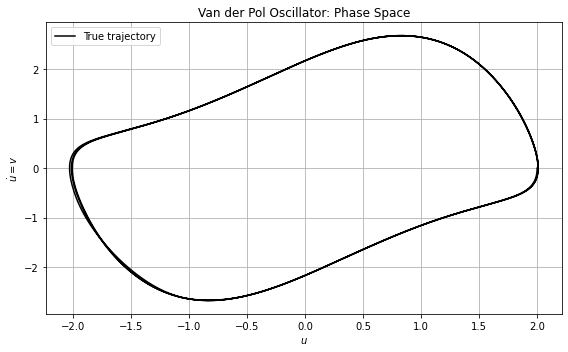

In [3]:
import matplotlib.pyplot as plt

# Step 3: Plot the phase space trajectory
plt.figure(figsize=(8, 5))
plt.plot(X[:, 0], X[:, 1], label="True trajectory", color='black')
plt.xlabel(r"$u$")
plt.ylabel(r"$\dot{u}=v$")
plt.title("Van der Pol Oscillator: Phase Space")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Observable Functions

To approximate the Koopman operator, we lift the dynamics into a finite-dimensional space of observables. We use polynomial observables in the variables $ u $ and $ v $, drawn from the space of total-degree polynomials:

$$
\mathcal{F}_m = \text{span}\{f_1, \dots, f_m\}, \quad f_j(u, v) \in \mathbb{P}_d(u, v),
$$

where $ \mathbb{P}_d(u, v) $ denotes the set of bivariate polynomials of total degree at most $ d $. For instance:
- $ d = 2 $: includes $ 1, u, v, u^2, uv, v^2 $
- $ d = 10 $: includes all monomials like $ u^4 v^3 $, up to total degree 10

We define the feature map $ f : \mathbb{R}^2 \to \mathbb{R}^m $ as:

$$
f(x) = \begin{bmatrix}
f_1(u, v) \\
\vdots \\
f_m(u, v)
\end{bmatrix},
\quad \text{where } x = [u, v]^\top.
$$

In [4]:
from sklearn.preprocessing import PolynomialFeatures

# Step 4: Define polynomial dictionary (e.g., degree 8)
poly = PolynomialFeatures(degree=8, include_bias=True)
F = poly.fit_transform(X)       # shape (n-1, m)
F_prime = poly.transform(X_prime)

The finite-approximation thus reads:

$$
F = \begin{bmatrix}
f(x_0)^\top \\
\vdots \\
f(x_{n-1})^\top
\end{bmatrix}
\in \mathbb{R}^{n \times m},
\quad
F' = \begin{bmatrix}
f(x_1)^\top \\
\vdots \\
f(x_n)^\top
\end{bmatrix}
\in \mathbb{R}^{n \times m}.
$$




## Extended Dynamic Mode Decomposition (EDMD)

### Methodology

The first approach to provide a finite-approximations of the Koopman operator was done in {cite}`2015_Williams_M_j-ns_edmd` by extending the *Dynamic Mode Decomposition* (DMD) to non-linear dynamics. It is defined as follows.

```{admonition} Definition: *EDMD*
:class: note
The EDMD operator is chosen as

$$
K = \underset{K\in\mathbb{R}^{m\times m}}{\mathrm{argmin}}\; \|F' - K F\|_F^2.
$$
```



```{admonition} Remark: EDMD generalizes DMD
:class: tip

If the observables are simply the coordinate functions $ f_i(x) = x_i $, then $ f(x) = x $, and the matrices $ F $ and $ F' $ consist of raw state snapshots. In this case, EDMD reduces exactly to DMD.
```


We emphasize that EDMD does **not** recover the full Koopman operator. It approximates how the Koopman operator acts on the selected observables:

$$
K f_j \approx f_j \circ T \quad \text{for all } j = 1,\dots,m,
$$
and only within the subspace $ \mathcal{F}_m $.


A rigorous analysis of the convergence properties of EDMD is provided by Korda and Mezić in their work {cite}`2018_Korda_M_j-ns_convergence-edmd`.

```{admonition} Convergence of EDMD 
:class: important

Let $ \mathcal{F}_m = \operatorname{span}\{f_1, \dots, f_m\} \subset L^2_\mu(\mathcal{X}) $ be a sequence of finite-dimensional subspaces such that:

$$
\overline{\bigcup_{m} \mathcal{F}_m} = L^2_\mu(\mathcal{X}).
$$

Assume that the snapshot pairs $ \{(x_t, x_t')\} $ are sampled either independently or ergodically from the measure $ \mu $, and that the observables $ \{f_1, \dots, f_m\} $ are linearly independent and belong to $ L^2_\mu(\mathcal{X}) $. Then:

- As the number of snapshots $ n \to \infty $, the empirical EDMD operator $ K $ converges to the projected Koopman operator $ \mathcal{P}_m \mathcal{K}|_{\mathcal{F}_m} $.
- As the dimension $ m \to \infty $, the projected operator $ \mathcal{P}_m \mathcal{K}|_{\mathcal{F}_m} $ converges to the true Koopman operator $ \mathcal{K} $ in the strong operator topology.
```


This two-step convergence implies that, with sufficiently rich observables and sample data, EDMD provides an increasingly accurate approximation of the Koopman operator. Notably, these results hold without requiring the finite-dimensional subspace $ \mathcal{F}_m $ to be invariant under the Koopman operator.

### Numerical Implementation


We now implement EDMD for the Van der Pol oscillator using the observables and snapshot data introduced earlier. We compare two numerical strategies for computing the Koopman approximation:
1. A **naive pseudoinverse-based** method,
2. A **more stable Gramian-based** method derived from the normal equations.

#### Naive Method (Pseudoinverse)

The naive method solves the least-squares problem:

$$
\underset{K\in\mathbb{R}^{m\times m}}{\mathrm{minimize}}\; \|F' - K F\|_F^2.
$$

which yields the closed-form solution $K = F'^\top F^\dagger$ using the Moore–Penrose pseudoinverse.

In [5]:
import numpy as np
from numpy.linalg import pinv

def edmd_naive(F, F_prime):
    return F_prime.T @ pinv(F.T)


Once we compute $ K $, we simulate the system forward in the lifted feature space by applying the linear map repeatedly, starting from the lifted initial condition $ f(x_0) $. The resulting sequence is then projected back to physical space by selecting the components of the observables corresponding to $ u $ and $ v $.

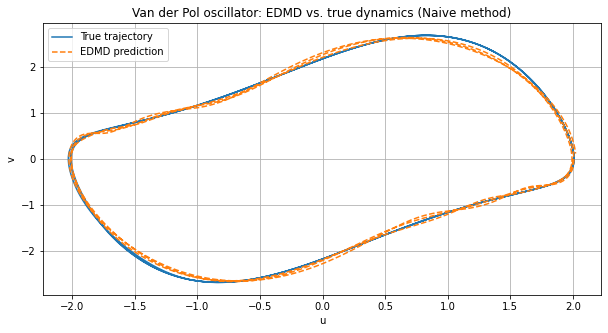

In [6]:
K = edmd_naive(F, F_prime)

n_pred = len(X)
f0 = F[0]                 # lifted initial condition
f_preds = [f0]
for _ in range(n_pred - 1):
    f_preds.append(K @ f_preds[-1])
F_preds = np.stack(f_preds)  # shape (n, m)

# Project back to state space (u, v ≈ first two coordinates)
X_pred = F_preds[:, 1:3]

# Plot original vs. predicted
plt.figure(figsize=(10, 5))
plt.plot(X[:, 0], X[:, 1], label="True trajectory")
plt.plot(X_pred[:, 0], X_pred[:, 1], '--', label="EDMD prediction")
plt.xlabel("u")
plt.ylabel("v")
plt.title("Van der Pol oscillator: EDMD vs. true dynamics (Naive method)")
plt.legend()
plt.grid(True)
plt.show()

Even though this approach is straightforward and efficient for small-scale problems, it may become unstable or inaccurate when the dictionary is large or poorly conditioned. In the next subsection, we address this using the Gramian formulation of EDMD.


#### Gramian-Based Method (Normal Equations)


While the naive method provides a valid least-squares solution, it requires computing the pseudoinverse of $ F \in \mathbb{R}^{n \times m} $, which can be numerically unstable or expensive when the dictionary of observables is large or poorly conditioned. A more robust alternative is to solve the same least-squares problem using the **normal equations**:

$$
\underset{K \in \mathbb{R}^{m \times m}}{\text{minimize}} \quad \|F' - K F\|_F^2.
$$

To derive the solution, we multiply both sides of the residual equation by $ F^\top $, yielding the **normal equations**:

$$
F^\top F K^\top = F^\top F',
$$

which is equivalent to:

$$
G K^\top = A^\top,
$$

where:
- $ G = F^\top F \in \mathbb{R}^{m \times m} $ is the **Gram matrix** of the observables,
- $ A = F^\top F' \in \mathbb{R}^{m \times m} $ is the **cross-covariance** between current and next observables.

Transposing both sides, we obtain the closed-form solution:

$$
K = A G^{-1}.
$$

To improve conditioning and ensure consistency with empirical expectations, we introduce a normalization factor $ \frac{1}{n} $, resulting in:

In [7]:
def edmd_gramian(F, F_prime):
    n = F.shape[0]
    A = (1/n) * F_prime.T @ F
    G = (1/n) * F.T @ F
    return A @ pinv(G)

```{admonition} Remark: When is the Gramian approach preferred?
:class: tip

The Gramian formulation is particularly well-suited when the number of observables $ m $ is much smaller than the number of snapshots $ n $. In this regime, the Gram matrix $ G = \frac{1}{n} F^\top F \in \mathbb{R}^{m \times m} $ is typically well-conditioned and cheap to invert. Moreover, it avoids computing the pseudoinverse of the larger matrix $ F \in \mathbb{R}^{n \times m} $, which can be unstable or computationally expensive when $ n \gg m $.

This is often the case in practice, where we have access to many time steps or trajectories (large $ n $) but use a limited dictionary of observables (moderate $ m $).
```

As before, we simulate the lifted dynamics under this linear approximation and project back to state space:

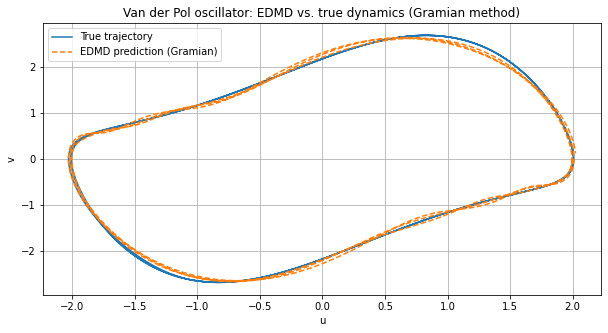

In [8]:
K = edmd_gramian(F, F_prime)

f0 = F[0]
f_preds = [f0]
for _ in range(n_pred - 1):
    f_preds.append(K @ f_preds[-1])
F_preds = np.stack(f_preds)
X_pred = F_preds[:, 1:3]

# Plot original vs. predicted
plt.figure(figsize=(10, 5))
plt.plot(X[:, 0], X[:, 1], label="True trajectory")
plt.plot(X_pred[:, 0], X_pred[:, 1], '--', label="EDMD prediction (Gramian)")
plt.xlabel("u")
plt.ylabel("v")
plt.title("Van der Pol oscillator: EDMD vs. true dynamics (Gramian method)")
plt.legend()
plt.grid(True)
plt.show()

We now compare the execution time of both methods:

In [9]:
import timeit

# Time both versions
time_naive = timeit.timeit(lambda: edmd_naive(F, F_prime), number=10)
time_gramian = timeit.timeit(lambda: edmd_gramian(F, F_prime), number=10)

print(f"Naive:   {time_naive:.4f} seconds")
print(f"Gramian: {time_gramian:.4f} seconds")

Naive:   0.0231 seconds
Gramian: 0.0034 seconds


## Beyond EDMD

Extended Dynamic Mode Decomposition (EDMD) provides a powerful framework for approximating the Koopman operator from data using a predefined set of observables. However, in many real-world applications, EDMD faces fundamental challenges — from the choice of observables to its scalability and robustness. 


```{admonition} Limitations of EDMD
:class: warning

While EDMD is conceptually simple and effective for small systems, it suffers from the following drawbacks:

- It requires a **manually chosen dictionary** of observables, which may not capture the system's nonlinear structure.
- Polynomial dictionaries grow **exponentially** with the state dimension and polynomial degree.
- Without regularization, it can **overfit** when the number of observables is large relative to the number of data points.
- It assumes **noise-free observations**, making it brittle in experimental or stochastic settings.
- It approximates the Koopman operator only on the finite-dimensional subspace spanned by the chosen observables.
```


This section introduces several important extensions that address them.



### Sparse EDMD

A natural improvement to EDMD is to promote **sparsity** in the learned Koopman matrix, selecting only the most relevant observables. This is especially helpful when using a large dictionary (e.g., high-degree polynomials or many basis functions), where overfitting and interpretability become concerns.

Sparse variants introduce regularization into the Koopman regression problem, encouraging the elimination of unnecessary terms.

```{admonition} Definition: *Sparse EDMD*
:class: note

Sparse EDMD augments the Koopman regression with a regularization term:

$$
\underset{K \in \mathbb{R}^{m \times m}}{\text{minimize}} \quad \|F' - K F\|_F^2 + \lambda \mathcal{R}(K),
$$

where the choice of $ \mathcal{R}(K) $ defines the sparsity structure:

- $ \|K\|_{1,1} = \sum_{i,j} |K_{i,j}| $: entrywise sparsity (using **Lasso**),
- $ \sum_i \|K_{i,:}\|_2 $: row-wise sparsity (using **MultiTask Lasso**).
```

These formulations allow us to reduce model complexity and discover the most influential observables, especially when $ m \gg n $.

In [10]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import MultiTaskLasso

def edmd_lasso(F, F_prime, alpha=1e-4):
    """
    Sparse EDMD with entrywise sparsity using Lasso (column-wise regression).
    Solves: min_K ||F' - F K^T||_F^2 + alpha * ||K||_1,1
    """
    m = F.shape[1]
    K = np.zeros((m, m))
    for j in range(m):
        model = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000)
        model.fit(F, F_prime[:, j])
        K[j, :] = model.coef_  # each row of K^T
    return K

def edmd_multitask(F, F_prime, alpha=1e-4):
    """
    Sparse EDMD with row-wise sparsity using MultiTaskLasso.
    Solves: min_K ||F' - F K^T||_F^2 + alpha * sum_i ||K[i,:]||_2
    """
    model = MultiTaskLasso(alpha=alpha, fit_intercept=False, max_iter=10000)
    model.fit(F, F_prime)  # each output column jointly
    return model.coef_.T  # scikit-learn returns shape (m_outputs, m_features)

### Kernel EDMD

To avoid explicitly constructing observables, **kernel methods** allow the Koopman operator to be approximated in **implicit feature spaces**. This technique is known as **Kernel EDMD** {cite}`2019_Klus_S_j-ns_kernel-edmd`.

```{admonition} Kernel EDMD
:class: note

By defining a kernel $ k(x, x') = \langle \phi(x), \phi(x') \rangle $, one can work with observables $ \phi(x) $ without ever computing them explicitly. The Koopman approximation is then constructed entirely from kernel evaluations between data points.

- Enables the use of infinite-dimensional feature spaces.
- Popular choices include polynomial and Gaussian RBF kernels.
- Scales better for high-dimensional state spaces.
```

See Klus et al. (2017) for a foundational treatment of Kernel EDMD.



### EDMD with Learned Observables

Rather than fixing a dictionary, one can **learn the observables directly from data** using neural networks. These methods train end-to-end to discover an embedding $ f_\theta(x) $ in which the dynamics evolve linearly:

```{admonition} Learned Observables (Koopman Autoencoders)
:class: note

Let $ f_\theta : \mathcal{X} \to \mathbb{R}^m $ be a neural network representing the observables. One seeks a Koopman matrix $ K \in \mathbb{R}^{m \times m} $ such that

$$
f_\theta(x_{t+1}) \approx K f_\theta(x_t)
$$

is satisfied over the data, while also possibly enforcing $ x_t \approx g_\theta(f_\theta(x_t)) $ via a decoder. This forms the basis of **Koopman autoencoders** and **Deep EDMD**.
```

This approach allows:
- Automatic discovery of observables,
- Better generalization to unseen data,
- Compatibility with nonlinear or partially observed systems.

Key references include Lusch, Kutz & Brunton (2018), and Takeishi et al. (2017).